In [66]:
import math
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import imgaug.augmenters as iaa
from imgaug.augmentables.kps import KeypointsOnImage
from imgaug.augmentables.kps import Keypoint
import matplotlib.pyplot as plt

In [44]:
def get_image_from_string(image_pixels_string):
    
    image_pixels_list = [int(point) for point in image_pixels_string.split(" ")]
    image_side = int(np.sqrt(len(image_pixels_list)))
    image = np.reshape(image_pixels_list, (image_side, image_side))
    image = np.expand_dims(image, 2)
    
    return image

def display_image(image):
    
    plt.figure()
    plt.imshow(image, cmap="gray")
    
    return

def get_image_keypoints(index):
    
    keypoints = train_df.iloc[index][:-1].values
    
    return keypoints

def draw_keypoints(image, keypoints):
    
    for i in np.linspace(0, len(keypoints)-2, 15, dtype=int):
        if math.isnan(keypoints[i]) or math.isnan(keypoints[i+1]):
            continue
        image[int(keypoints[i+1]), int(keypoints[i])] = 255
        
    return image

In [45]:
train_df = pd.read_csv("../data/training.csv")

In [46]:
train_df

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7044,67.402546,31.842551,29.746749,38.632942,NaN,NaN,NaN,NaN,NaN,NaN,...,67.029093,NaN,NaN,NaN,NaN,NaN,NaN,50.426637,79.683921,71 74 85 105 116 128 139 150 170 187 201 209 2...
7045,66.134400,38.365501,30.478626,39.950198,NaN,NaN,NaN,NaN,NaN,NaN,...,66.626011,NaN,NaN,NaN,NaN,NaN,NaN,50.287397,77.983023,60 60 62 57 55 51 49 48 50 53 56 56 106 89 77 ...
7046,66.690732,36.845221,31.666420,39.685042,NaN,NaN,NaN,NaN,NaN,NaN,...,67.515161,NaN,NaN,NaN,NaN,NaN,NaN,49.462572,78.117120,74 74 74 78 79 79 79 81 77 78 80 73 72 81 77 1...
7047,70.965082,39.853666,30.543285,40.772339,NaN,NaN,NaN,NaN,NaN,NaN,...,66.724988,NaN,NaN,NaN,NaN,NaN,NaN,50.065186,79.586447,254 254 254 254 254 238 193 145 121 118 119 10...


In [47]:
train_df = train_df.fillna(0)

In [48]:
no_rows, no_columns = train_df.shape

In [49]:
labels = []

for i in range(no_rows):
    labels.append(train_df.iloc[i][:-1].values.astype(float))

In [124]:
images = []

for i in range(no_rows):
    images.append(get_image_from_string(train_df.iloc[i]["Image"]).astype(float))

In [125]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.1, random_state=42)

In [126]:
BATCH_SIZE = 10
IMG_SIZE = 96
NUM_KEYPOINTS = 30

In [127]:
class KeyPointsDataset(tf.keras.utils.Sequence):
    
    def __init__(self, images, keypoints, augmentations, batch_size=BATCH_SIZE, train=True):
        
        self.images = images
        self.keypoints = keypoints
        self.augmentations = augmentations
        self.batch_size = batch_size
        self.train = train
        self.indexes = np.arange(len(self.images))

    def __len__(self):
        
        return len(self.images) // self.batch_size

    def __getitem__(self, index):
        
        indexes = self.indexes[index * self.batch_size : (index+1) * self.batch_size]
        images = [self.images[k] for k in indexes]
        keypoints = [self.keypoints[k] for k in indexes]
        images, keypoints = self.data_generation(images, keypoints)

        return (images, keypoints)

    def data_generation(self, images, keypoints):
        
        batch_images = np.empty((self.batch_size, IMG_SIZE, IMG_SIZE, 1), dtype="float32")
        batch_keypoints = np.empty((self.batch_size, NUM_KEYPOINTS), dtype="float32")

        for i, (image, keypoint) in enumerate(zip(images, keypoints)):
            keypoint_pairs = []
            
            for j in np.arange(0, len(keypoint), 2):
                keypoint_pairs.append(Keypoint(x=int(keypoint[j]), y=int(keypoint[j+1])))
            
            kps_obj = KeypointsOnImage(keypoint_pairs, shape=image.shape)
            (new_image, new_kps_obj) = self.augmentations(image=image, keypoints=kps_obj)
            batch_images[i] = new_image
            kp_temp = []

            for keypoint in new_kps_obj:
                kp_x = np.nan_to_num(keypoint.x)
                kp_y = np.nan_to_num(keypoint.y)
                
                if kp_x < 0 or kp_x > 95:
                    kp_x = 0
                if kp_y < 0 or kp_y > 95:
                    kp_y = 0
                    
                kp_temp.append(kp_x)
                kp_temp.append(kp_y)

            batch_keypoints[i] = kp_temp
        
        return batch_images, batch_keypoints

In [135]:
train_aug = iaa.Sequential([iaa.Resize(IMG_SIZE, interpolation="linear"), iaa.Fliplr(0.5), iaa.Sometimes(0.5, iaa.Affine(rotate=(-15, 15), scale=(0.5, 1.5)))])
test_aug = iaa.Sequential([iaa.Resize(IMG_SIZE, interpolation="linear")])

In [136]:
train_dataset = KeyPointsDataset(X_train, y_train, train_aug)

In [137]:
sample_images, sample_keypoints = next(iter(train_dataset))

In [138]:
sample_images.shape

(10, 96, 96, 1)

In [139]:
sample_keypoints.shape

(10, 30)

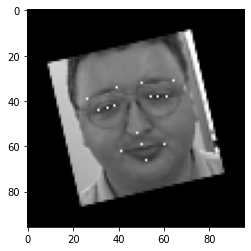

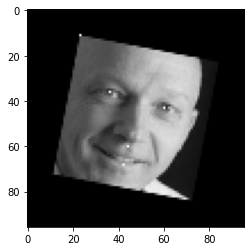

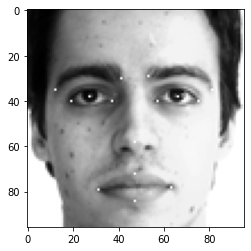

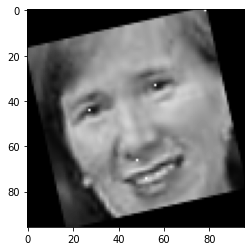

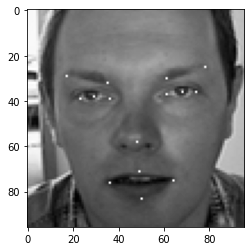

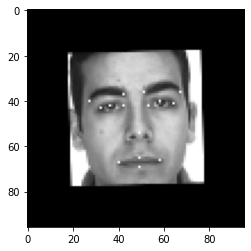

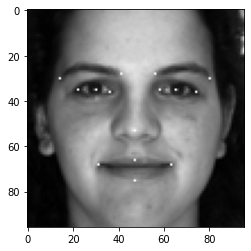

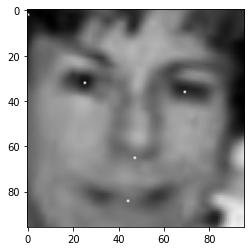

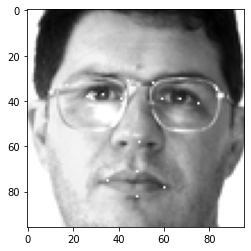

In [140]:
for i in range(1, sample_images.shape[0]):
    image_w_keypoints = draw_keypoints(sample_images[i], sample_keypoints[i])
    display_image(image_w_keypoints)